# References / Acknowledgements
This project would not have been possible without the help of the following:
- [NumPy](https://numpy.org/)
- [Pandas](https://pandas.pydata.org/)
- [scikit-learn](https://scikit-learn.org/)
- [TensorFlow](https://www.tensorflow.org/)
- [Matplotlib](https://matplotlib.org/)
- Dr Jake Lee, UNC Charlotte
- Devdan
- [Introduction to the Data Peak](https://www.ubisoft.com/en-us/game/rainbow-six/siege/news-updates/2fQ8bGRr6SlS7B4u5jpVt1/introduction-to-the-data-peek-velvet-shell-statistics) - Ubisoft
- [How to Encode Categorical Values for Multiple Columns | Scikit-Learn](https://medium.com/@merilainen.vili/how-to-encode-categorical-values-for-multiple-columns-scikit-learn-66fd3671384b) - Medium, Vili Meriläinen

# Rainbow Six Siege Y2S1 Dataset Analysis

Using data collected by Ubisoft and published in the first and final entry in the Data Peek series for Tom Clancy's Rainbow Six Siege, we will be analysing all data regarding a player and the current round to determine something.

This analysis was completed with two models: K-Nearest Neighbour and a Neural Network.
The KNN model determines a user's platform based on the data mentioned before.
The Neural Network model determines a user's rank, once again based on the data mentioned.

Different objectives were chosen to make the most of the large dataset and the variety of subjects that could be predicted with it.

In [1]:
import numpy as np
import pandas as pd

## Loading Data: Data Peek
This dataset was published by Ubisoft in a blog post titled "[Introduction to the Data Peek: Velvet Shell Statistics](https://www.ubisoft.com/en-us/game/rainbow-six/siege/news-updates/2fQ8bGRr6SlS7B4u5jpVt1/introduction-to-the-data-peek-velvet-shell-statistics)".
This was to be the first of a series of seasonal releases of player statistics for analysis by the community. 
Seven years have since past without a second dataset being published.

We are utilising the second data file published, "Objectives Data".
This file consists of maps, objective locations, player ranks and operators, and all together how they performed.
It was chosen for its size and contents.

### Data Cleaning
The data has been slightly modified before being read.
The original file contained non-ASCII characters, preventing Pandas from being able to read the CSV.
The offending character was a non-standard hyphen and was removed.

Done within this Notebook though was dropping the date column as it was deemed unnecessary for the analysis.
Additionally, only a sample of 0.16% of the dataset is going to be used, equalling around 14,000 samples.
This was done due to computation limits.

In [2]:
data = pd.read_csv('datadump_S5_summary_objectives-cleaned.csv', delimiter=';').drop(columns=['dateid']).sample(frac=0.0016, random_state=42)
data

,platform,gamemode,mapname,objectivelocation,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks
353645,PC,PvP HOSTAGE,CHALET,LIBRARY,Bronze,Defender,GSG9-JAGER,0,1,1,1
2116257,PC,PvP SECURE AREA,CLUB HOUSE,BEDROOM,Copper,Defender,SAS-SMOKE,4,6,5,7
3180748,PS4,PvP BOMB,KANAL,KITCHEN / PROJECTOR ROOM,Bronze,Defender,SAS-MUTE,4,3,4,6
373704,PC,PvP BOMB,CONSULATE,GARAGE / CAFETERIA,Bronze,Defender,JTF2-FROST,2,0,5,5
1970978,PC,PvP SECURE AREA,BARTLETT U.,CLASSROOM,Bronze,Defender,GSG9-JAGER,3,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...
609897,PC,PvP SECURE AREA,KAFE DOSTOYEVSKY,TRAIN MUSEUM,Silver,Defender,BOPE-CAVEIRA,13,22,20,24
571515,PC,PvP HOSTAGE,KAFE DOSTOYEVSKY,KITCHEN GRILL,Gold,Defender,GSG9-JAGER,1,2,6,6
2716702,PS4,PvP BOMB,HOUSE,TRAINING ROOM / GARAGE,Bronze,Defender,JTF2-FROST,4,7,9,11
6897752,XONE,PvP BOMB,CONSULATE,CONSUL OFFICE / MEEETING ROOM,Bronze,Defender,GIGN-DOC,3,4,2,4


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14057 entries, 353645 to 6024931
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   platform           14057 non-null  object
 1   gamemode           14057 non-null  object
 2   mapname            14057 non-null  object
 3   objectivelocation  14057 non-null  object
 4   skillrank          14057 non-null  object
 5   role               14057 non-null  object
 6   operator           14057 non-null  object
 7   nbwins             14057 non-null  int64 
 8   nbkills            14057 non-null  int64 
 9   nbdeaths           14057 non-null  int64 
 10  nbpicks            14057 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 1.3+ MB


In [4]:
data.describe()

,nbwins,nbkills,nbdeaths,nbpicks
count,14057.000000,14057.000000,14057.000000,14057.000000
mean,4.973536,6.798392,6.861777,9.745251
std,9.570977,14.187120,12.975466,18.164345
min,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,2.000000
50%,2.000000,3.000000,3.000000,4.000000
75%,5.000000,7.000000,7.000000,10.000000
max,215.000000,392.000000,328.000000,427.000000


## Data Preprocessing
### Deduplication
The dataset included many near duplicate lines such as the following:
```csv
platform;dateid;gamemode;mapname;objectivelocation;skillrank;role;operator;nbwins;nbkills;nbdeaths;nbpicks
PC;20170511;PvP BOMB;BANK;EXECUTIVE LOUNGE / CEO OFFICE;Bronze;Attacker;JTF2-BUCK;1;0;1;1
PC;20170512;PvP BOMB;BANK;EXECUTIVE LOUNGE / CEO OFFICE;Bronze;Attacker;JTF2-BUCK;1;0;1;1
PC;20170513;PvP BOMB;BANK;EXECUTIVE LOUNGE / CEO OFFICE;Bronze;Attacker;JTF2-BUCK;0;1;1;1
```

The only thing separating the lines is the date from which the data was collected.
As such, it would be pointless and counterintuitive to keep all instances of the data rather than combining the samples and summing together the last four columns.
That is done in this step and removes around 800 lines.

In [5]:
aggregate = {
    'nbwins': 'sum',
    'nbkills': 'sum',
    'nbdeaths': 'sum',
    'nbpicks': 'sum'
}
dedup_data = data.groupby([data['platform'], data['gamemode'], data['mapname'], data['objectivelocation'], data['skillrank'], data['role'], data['operator']]).aggregate(aggregate).reset_index()
dedup_data

,platform,gamemode,mapname,objectivelocation,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks
0,PC,PvP BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Defender,BOPE-CAVEIRA,2,1,2,3
1,PC,PvP BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Defender,GIGN-ROOK,3,4,4,6
2,PC,PvP BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Copper,Attacker,GSG9-RESERVE,0,1,1,1
3,PC,PvP BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Copper,Attacker,NAVYSEAL-BLACKBEARD,1,1,2,2
4,PC,PvP BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Copper,Attacker,SAT-HIBANA,2,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...
13206,XONE,PvP SECURE AREA,YACHT,KITCHEN,Unranked,Defender,BOPE-CAVEIRA,3,4,4,6
13207,XONE,PvP SECURE AREA,YACHT,KITCHEN,Unranked,Defender,GSG9-BANDIT,10,10,14,22
13208,XONE,PvP SECURE AREA,YACHT,KITCHEN,Unranked,Defender,GSG9-RESERVE,1,4,2,3
13209,XONE,PvP SECURE AREA,YACHT,KITCHEN,Unranked,Defender,JTF2-FROST,2,2,1,2


### One-Hot Encoding
We'll be making use of one-hot encoding to encode the string data as numeric values.
One-hot encoding was chosen for its effectiveness, intuitiveness, and ability to prevent misinterpretations of higher numbers being more important, an issue with other encoding methods.

This produces a new DataFrame with new columns representing each platform, gamemode, map, objective location, rank, role, and operator though.
The resulting DataFrame now has 212 columns as opposed to the previous 11.

In [6]:
from sklearn.preprocessing import OneHotEncoder

def encode_strings(df, str_columns=['platform', 'gamemode', 'mapname', 'objectivelocation', 'skillrank', 'role', 'operator']):
    df = df.reset_index().drop(['index'], axis=1)
    enc = OneHotEncoder(sparse_output=False)
    onehot_enc_arr = enc.fit_transform(df[str_columns])
    onehot_enc_df = pd.DataFrame(onehot_enc_arr, columns=enc.get_feature_names_out(str_columns))
    enc_df = pd.concat([df, onehot_enc_df], axis=1).drop(str_columns, axis=1)
    return enc_df

enc_df = encode_strings(dedup_data)
enc_df

,nbwins,nbkills,nbdeaths,nbpicks,platform_PC,platform_PS4,platform_XONE,gamemode_PvP BOMB,gamemode_PvP HOSTAGE,gamemode_PvP SECURE AREA,...,operator_SPETSNAZ-FUZE,operator_SPETSNAZ-GLAZ,operator_SPETSNAZ-KAPKAN,operator_SPETSNAZ-RESERVE,operator_SPETSNAZ-TACHANKA,operator_SWAT-ASH,operator_SWAT-CASTLE,operator_SWAT-PULSE,operator_SWAT-RESERVE,operator_SWAT-THERMITE
0,2,1,2,3,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,4,4,6,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,1,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,2,2,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,1,2,2,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13206,3,4,4,6,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13207,10,10,14,22,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13208,1,4,2,3,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13209,2,2,1,2,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
enc_df.describe()

,nbwins,nbkills,nbdeaths,nbpicks,platform_PC,platform_PS4,platform_XONE,gamemode_PvP BOMB,gamemode_PvP HOSTAGE,gamemode_PvP SECURE AREA,...,operator_SPETSNAZ-FUZE,operator_SPETSNAZ-GLAZ,operator_SPETSNAZ-KAPKAN,operator_SPETSNAZ-RESERVE,operator_SPETSNAZ-TACHANKA,operator_SWAT-ASH,operator_SWAT-CASTLE,operator_SWAT-PULSE,operator_SWAT-RESERVE,operator_SWAT-THERMITE
count,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000,...,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000
mean,5.292029,7.233745,7.301188,10.369313,0.281886,0.370827,0.347286,0.332677,0.263190,0.404133,...,0.028991,0.031792,0.027553,0.012111,0.015669,0.035349,0.028158,0.032549,0.014155,0.032019
std,10.331783,15.298796,14.046238,19.670559,0.449935,0.483045,0.476126,0.471190,0.440381,0.490742,...,0.167788,0.175452,0.163694,0.109386,0.124195,0.184668,0.165431,0.177459,0.118134,0.176057
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,7.000000,7.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,215.000000,392.000000,328.000000,427.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visualisation
### Pairplots
Below is the data visualised using a Seaborn Pairplot. 
The data is coloured by the player's rank and compares number of wins, kills, deaths, and picks a specific operator-objective pairing received.

This first pairgrid is of the data subset before combining lines in the deduplication step.

In [8]:
from seaborn import pairplot, catplot
hue_order = ['Unranked', 'Copper', 'Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond']

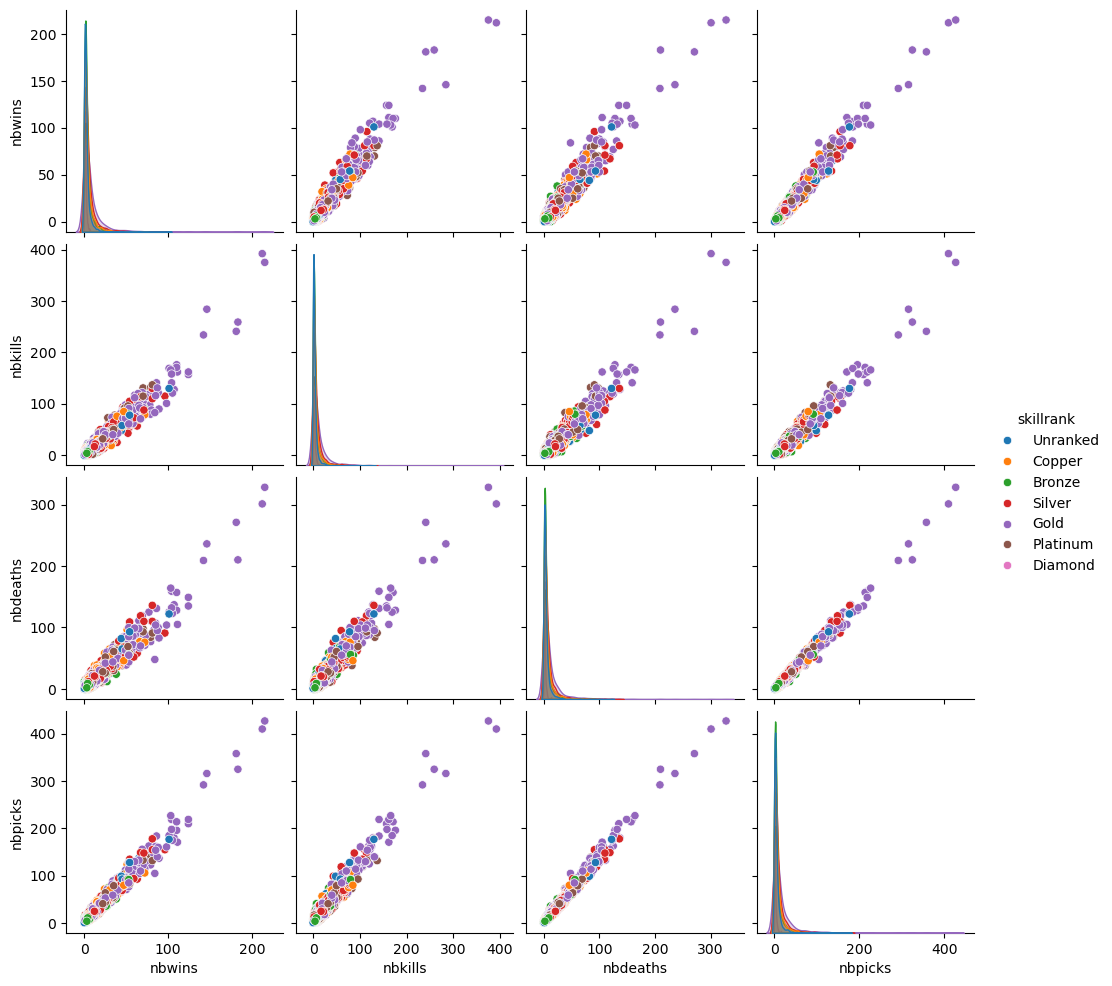

In [9]:
pairplot(data, hue='skillrank', hue_order=hue_order)

This second pairgrid is of the data subset after combining lines in the deduplication step.

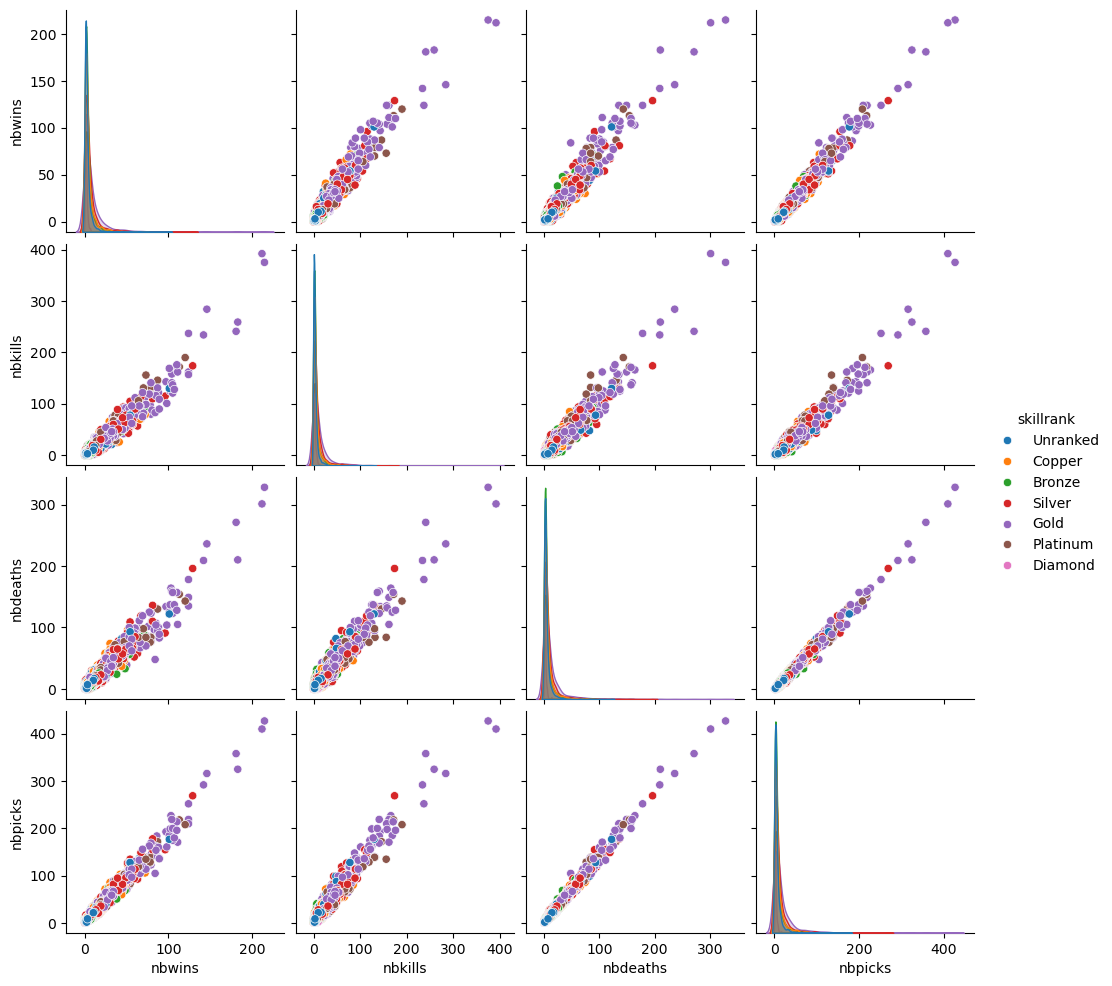

In [10]:
pairplot(dedup_data, hue='skillrank', hue_order=hue_order)

The following few plots plot a few of the categories from the dataset and displays the number of kills and wins per each category.
### Wins and Kills by Rank

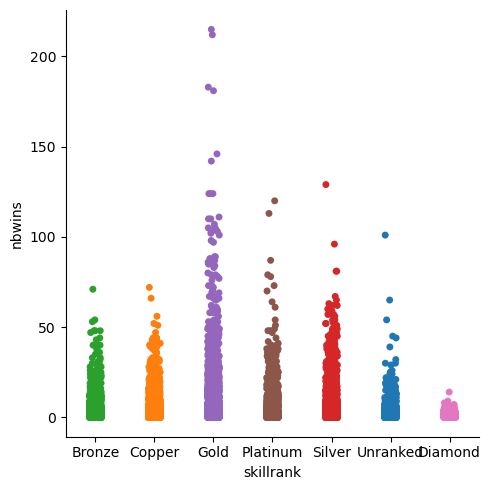

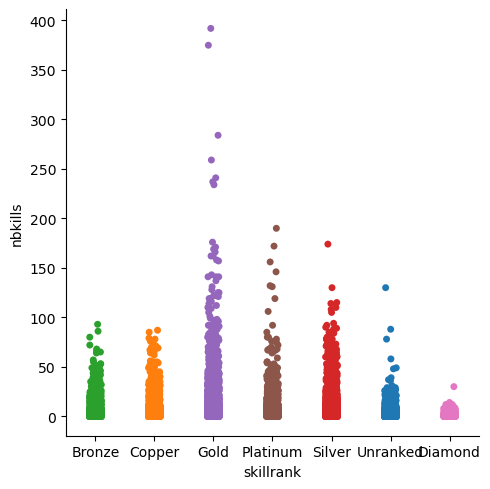

In [11]:
catplot(data=dedup_data, x='skillrank', y='nbwins', hue='skillrank', hue_order=hue_order)
catplot(data=dedup_data, x='skillrank', y='nbkills', hue='skillrank', hue_order=hue_order)

### Wins and Kills by Gamemode

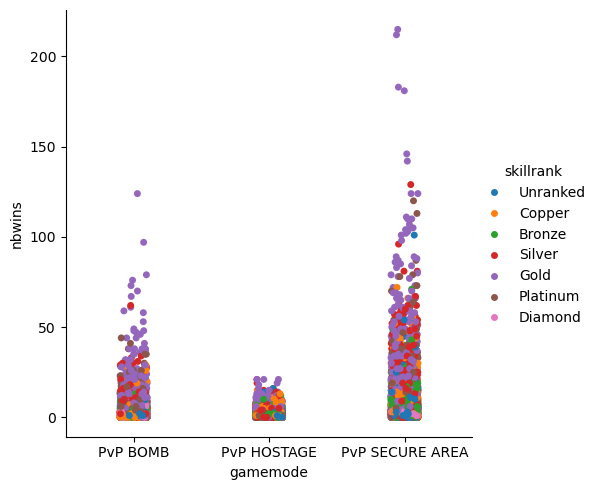

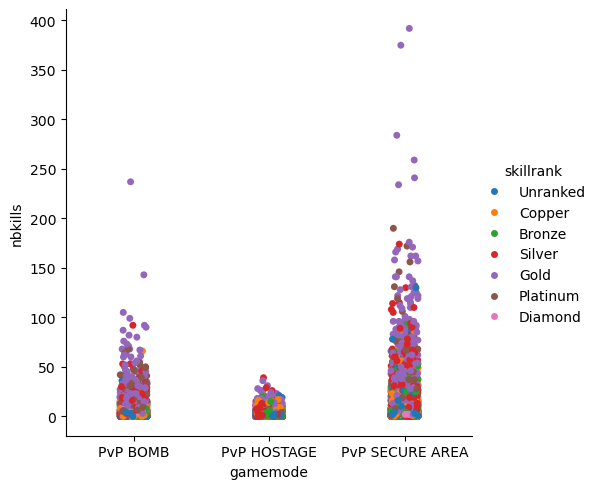

In [12]:
catplot(data=dedup_data, x='gamemode', y='nbwins', hue='skillrank', hue_order=hue_order)
catplot(data=dedup_data, x='gamemode', y='nbkills', hue='skillrank', hue_order=hue_order)

### Wins and Kills by Platform

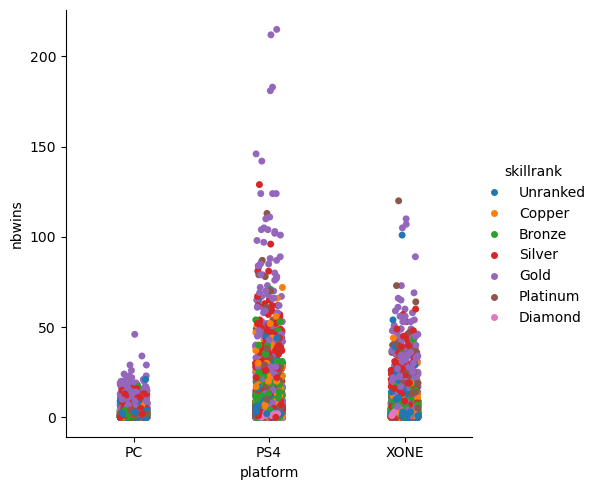

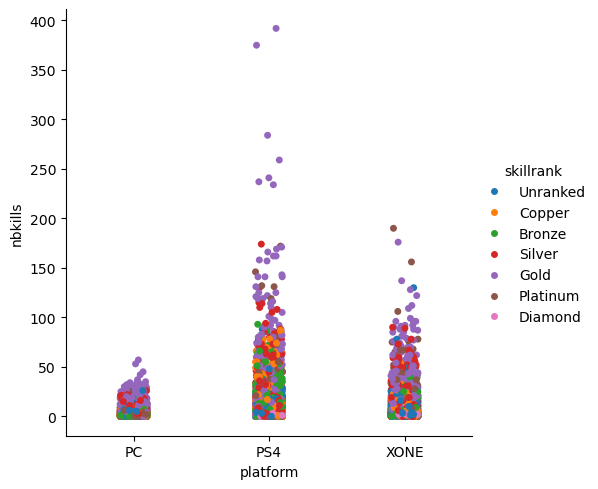

In [13]:
catplot(data=dedup_data, x='platform', y='nbwins', hue='skillrank', hue_order=hue_order)
catplot(data=dedup_data, x='platform', y='nbkills', hue='skillrank', hue_order=hue_order)

## Metrics
To ensure a working model, we will need to test accuracy.
This will be done in a few ways, including error functions, accuracy calculations, and a confusion matrix.

The two error functions used will be root mean squared error and mean squared error.
These were chosen primarily due to familiarity.

In [14]:
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error as mse

In [15]:
# Credit: Jake Lee, UNC Charlotte
# Taken from ITCS 3156 homework assignments
def accuracy(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Computes the accuracy between two 1D vectors

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

        Return:
            A float corresponding to the accuracy
    """
    y =  y.reshape(-1,) # reshape to make 1D vector for consistency
    y_hat = y_hat.reshape(-1,) # reshape to make 1D vector for consistency

    are_same = y == y_hat
    total_correct = np.sum(are_same)
    total_samples = len(y)
    
    print(f"Accuracy ratio: {total_correct}/{total_samples}")
    
    return total_correct / total_samples

In [16]:
# Credit: Jake Lee, UNC Charlotte
# Taken from ITCS 3156 homework assignments
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt
def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_names = None # type: Dict[int, str]
) -> pd.DataFrame:
    """ Plots a pretty and labeld version of Sklerarn's confusion matrix

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

            class_names: Dictionary mapping labels to class names.

                Example: {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

        Returns:
            A confusion matrix casted as a DataFrame
    """
    y =  y.flatten() # reshape to make 1D vector for consistency
    y_hat = y_hat.flatten() # reshape to make 1D vector for consistency
    
    cfm = confusion_matrix(y_true=y, y_pred=y_hat)    
    
    labels = np.sort(np.unique(y))
    if class_names is not None:
        classes = []
        for l in labels:
            class_name = class_names.get(l, l)
            classes.append(class_name)
        labels = classes
        
    columns, index = labels, labels
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    heatmap(cfm_df, annot=True, fmt='g')
    plt.show()
    return cfm_df

## Data Splitting
Before training any models, we need to split the data set.
Even more, that is.
We will be splitting the data into a training set, validation set, and testing set.
The split will be 64% training, 16% validation, and 20% testing.

In [17]:
# Credit: Jake Lee, UNC Charlotte
# Taken from ITCS 3156 homework assignments
from sklearn.model_selection import train_test_split
def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
    seed: int = 42
):
    """ Randomizes and then splits the data into train, validation, and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 
    """
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.8, random_state=seed)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=seed)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

## K-Nearest Neighbour
Having loaded, cleaned up, and visualised some of the data, now let's start 'training'.
For this first model, we'll be making use of K-Nearest Neighbour, or KNN.
The purpose of this model will be to predict a player's platform given all other information about them.

In [18]:
# KNN does not need validation set
X_trn, X_tst, y_trn, y_tst = train_test_split(dedup_data, dedup_data['platform'], train_size=0.8, random_state=42)

# pass values through one-hot encoding
X_trn = encode_strings(X_trn)
X_tst = encode_strings(X_tst)
y_trn = encode_strings(pd.DataFrame(y_trn), ['platform'])
y_tst = encode_strings(pd.DataFrame(y_tst), ['platform'])

In [19]:
from sklearn.neighbors import KNeighborsClassifier

# create the knn classifier
knn = KNeighborsClassifier(
    n_neighbors=15,
    weights='uniform'
)
# fit the model to training data
knn.fit(X_trn, y_trn)

KNeighborsClassifier(n_neighbors=15)

Accuracy ratio: 7537/7929
0.9505612309244545


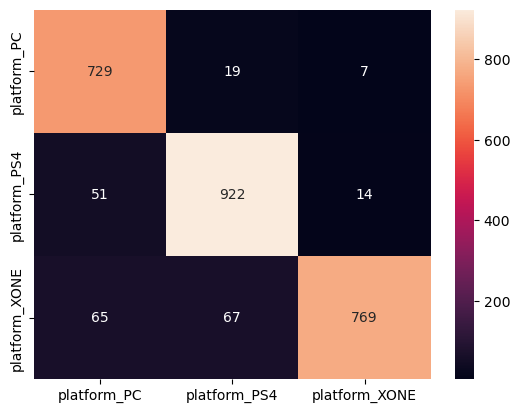

,platform_PC,platform_PS4,platform_XONE
platform_PC,729,19,7
platform_PS4,51,922,14
platform_XONE,65,67,769


In [20]:
# make a prediction based on testing data
y_tst_hat = knn.predict(X_tst)
# display predictions
print(accuracy(y_tst.to_numpy(), y_tst_hat))
plot_confusion_matrix(
    np.argmax(y_tst, axis=1), 
    np.argmax(y_tst_hat, axis=1), 
    class_names={
        0: 'platform_PC',
        1: 'platform_PS4',
        2: 'platform_XONE'
    }
)

## Neural Network
The second model we'll be training will be a neural network.
This model will be used to predict a rank given its performance on a given map, objective, gamemode, operator, role, and platform.

In [21]:
# split dataset into training, validation, and testing
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(dedup_data, dedup_data['skillrank'], seed=2)

# encode all subsets
X_trn = encode_strings(X_trn)
X_vld = encode_strings(X_vld)
X_tst = encode_strings(X_tst)
y_trn = encode_strings(pd.DataFrame(y_trn), ['skillrank'])
y_vld = encode_strings(pd.DataFrame(y_vld), ['skillrank'])
y_tst = encode_strings(pd.DataFrame(y_tst), ['skillrank'])

# print shapes to verify all match in number of rows
print(X_trn.shape, X_vld.shape, X_tst.shape)
print(y_trn.shape, y_vld.shape, y_tst.shape)

(8454, 212) (2114, 212) (2643, 212)
(8454, 7) (2114, 7) (2643, 7)


In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

# create neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(106, activation='relu'),
    tf.keras.layers.Dense(53, activation='relu'),
    tf.keras.layers.Dense(27, activation='relu'),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(7)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['root_mean_squared_error']
)
# fit neural network to training data, validate with validation
history = model.fit(X_trn, y_trn, epochs=10, validation_data=(X_vld, y_vld))

2024-12-09 22:23:21.280067: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 22:23:21.350621: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 22:23:21.393918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733801001.460292  385922 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733801001.467780  385922 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 22:23:21.572620: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Epoch 1/10


2024-12-09 22:23:23.934921: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1244 - root_mean_squared_error: 0.3503 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1931
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339 - root_mean_squared_error: 0.1831 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - root_mean_squared_error: 0.1166 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - root_mean_squared_error: 0.0620 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0730
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0599
Epoch 7/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

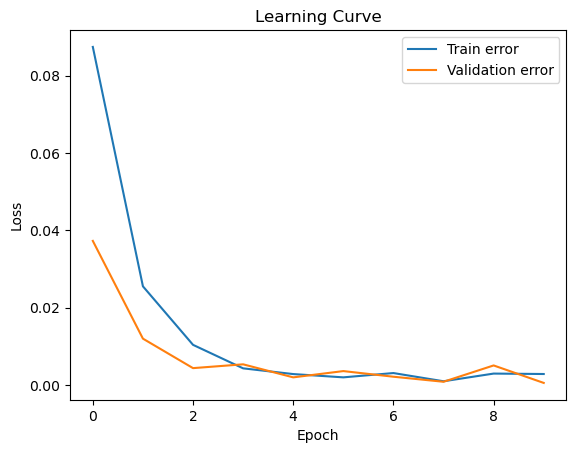

265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
Training RMSE: 0.02099887026459783
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
Validation RMSE: 0.022007874840820094
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
Testing RMSE: 0.021490869619798236


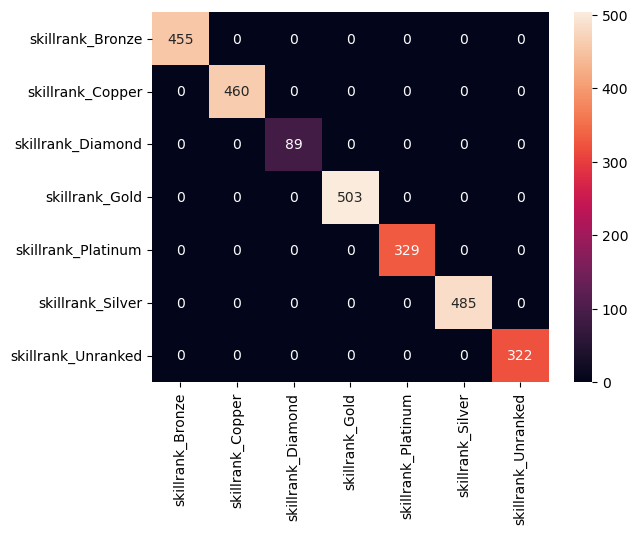

,skillrank_Bronze,skillrank_Copper,skillrank_Diamond,skillrank_Gold,skillrank_Platinum,skillrank_Silver,skillrank_Unranked
skillrank_Bronze,455,0,0,0,0,0,0
skillrank_Copper,0,460,0,0,0,0,0
skillrank_Diamond,0,0,89,0,0,0,0
skillrank_Gold,0,0,0,503,0,0,0
skillrank_Platinum,0,0,0,0,329,0,0
skillrank_Silver,0,0,0,0,0,485,0
skillrank_Unranked,0,0,0,0,0,0,322


In [23]:
# plot training loss
plt.plot(history.history['loss'], label='Train error')
plt.plot(history.history['val_loss'], label='Validation error')
plt.title("Learning Curve")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# make prediction based on training data
y_trn_hat = model.predict(X_trn)
print(f'Training RMSE: {rmse(y_trn, y_trn_hat)}')

# make prediction based on validation data
y_vld_hat = model.predict(X_vld)
print(f'Validation RMSE: {rmse(y_vld, y_vld_hat)}')

# make prediction based on testing data
y_tst_hat = model.predict(X_tst)
print(f'Testing RMSE: {rmse(y_tst, y_tst_hat)}')

# generate confusion matrix based on testing data
plot_confusion_matrix(
    np.argmax(y_tst, axis=1), 
    np.argmax(y_tst_hat, axis=1), 
    class_names={
        0: 'skillrank_Bronze',
        1: 'skillrank_Copper',
        2: 'skillrank_Diamond',
        3: 'skillrank_Gold',
        4: 'skillrank_Platinum',
        5: 'skillrank_Silver',
        6: 'skillrank_Unranked'
    }
)